In [17]:
!pip install transformers datasets scikit-learn accelerate peft bitsandbytes

In [16]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available

True


In [4]:
import torch
import pandas as pd
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random
import os


In [5]:
# Step 3: Configurations

from transformers import TrainingArguments
seed_value = 8642
config = {
    "BERT": {
        "model_settings": {
            "model_type": "bert-base-uncased",
            "num_labels": 2
        },
        "training_args": TrainingArguments(
            output_dir="final_BERT",
            num_train_epochs=6,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=1,
            weight_decay=0.1,
            learning_rate=5e-5,
            do_train=True,
            do_eval=True,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            seed=seed_value
        )

    }

}


In [6]:
# Step 4: Utility Functions

def set_all_seeds(seed_value=seed_value):
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()


In [20]:
import os
from transformers import TrainerCallback

class SaveModelAndTokenizerCallback(TrainerCallback):
    def __init__(self, tokenizer, model, output_dir):
        self.tokenizer = tokenizer
        self.model = model
        self.output_dir = output_dir

    def on_save(self, args, state, control, **kwargs):
        checkpoint_dir = os.path.join(self.output_dir, f"checkpoint-{state.global_step}")
        
        # Create the checkpoint directory if it doesn't exist
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Ensure that all tensors in the model are contiguous
        self.make_model_contiguous(self.model)

        # Save model and tokenizer inside the checkpoint directory
        self.model.save_pretrained(checkpoint_dir)
        self.tokenizer.save_pretrained(checkpoint_dir)
        print(f"Model and tokenizer saved to {checkpoint_dir}")

    def make_model_contiguous(self, model):
        """Make sure all model tensors are contiguous"""
        for param in model.parameters():
            if not param.is_contiguous():
                param.data = param.data.contiguous()

In [21]:
# Step 5: Define the FineTuner Class

from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

class FineTuner:

    def __init__(self, model, tokenizer, training_args):
        self.model = model
        self.tokenizer = tokenizer
        self.training_args = training_args
        self.trainer = None

    def tokenize_dataset(self, dataset):
        def tokenize_function(examples):
            return self.tokenizer(examples['sentence'], truncation=True, max_length=512)
        return dataset.map(tokenize_function, batched=True, remove_columns=['sentence'])

    def train(self, train_dataset, val_dataset):
        # Tokenize datasets
        tokenized_train_dataset = self.tokenize_dataset(train_dataset)
        tokenized_val_dataset = self.tokenize_dataset(val_dataset)

        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        def compute_metrics(p):
            labels = p.label_ids
            preds = p.predictions.argmax(-1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
            acc = accuracy_score(labels, preds)
            return {
                'accuracy': acc,
                'f1': f1,
                'precision': precision,
                'recall': recall
            }

        # Early stopping callback
        early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

        save_model_and_tokenizer_callback = SaveModelAndTokenizerCallback(
            tokenizer=self.tokenizer,
            model=self.model,
            output_dir=self.training_args.output_dir
        )

        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=tokenized_train_dataset,
            eval_dataset=tokenized_val_dataset,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping_callback, save_model_and_tokenizer_callback],  # Add the custom callback here
        )

        self.trainer.train()


In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def initialize_model(model_name, config):

    if model_name == "BERT":
        model_type = config["BERT"]["model_settings"]["model_type"]
        model = AutoModelForSequenceClassification.from_pretrained(model_type, num_labels=config["BERT"]["model_settings"]["num_labels"])
        tokenizer = AutoTokenizer.from_pretrained(model_type)

    return model, tokenizer

# Initialize model and tokenizer
model_name = "BERT"
model, tokenizer = initialize_model(model_name, config)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
from datasets import load_dataset, DatasetDict

def load_datasets(train_file_path,validation_file_path,test_file_path, test_ssc_file_path):
    """
    Load train, test, and ssc test datasets from CSV files.

    Args:
        train_file_path (str): Path to the training dataset CSV file.
        test_file_path (str): Path to the balanced testing dataset CSV file.
        test_ssc_file_path (str): Path to the ssc testing dataset csv file.

    Returns:
        DatasetDict: A dictionary containing the training and testing datasets.
    """
    try:
        # Load the training dataset
        train_dataset = load_dataset('csv', data_files=train_file_path)['train']
        print("Train Dataset Loaded Successfully.")

        # Load the balanced testing dataset
        test_dataset = load_dataset('csv', data_files=test_file_path)['train']  # Accessing 'train' because it returns 'train'
        print("Test Dataset Loaded Successfully.")
        
        # Load the ssc testing dataset
        test_ssc_dataset = load_dataset('csv', data_files=test_ssc_file_path)['train']
        print("Test SSC Dataset Loaded Successfully.")

        # Load the validation dataset
        validation_dataset = load_dataset('csv', data_files=validation_file_path)['train']
        print("Validation Dataset Loaded Successfully.")

        # Create a DatasetDict
        dataset_dict = DatasetDict({
            'train': train_dataset,
            'validation': validation_dataset,
            'test': test_dataset,  # Balanced test dataset
            'test_ssc': test_ssc_dataset  # SSC test dataset
        })

        return dataset_dict

    except Exception as e:
        print("An error occurred while loading the datasets:", str(e))
        return None


# Example usage
train_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_train_dataset.csv'  
validation_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_validation_dataset.csv'
test_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_test_dataset.csv'
test_ssc_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_social_science_test_dataset.csv'

# Load the datasets
datasets = load_datasets(train_file_path, validation_file_path, test_file_path, test_ssc_file_path)

# Check if datasets are loaded successfully
if datasets:
    print("Datasets loaded successfully!")
else:
    print("Failed to load datasets.")


Train Dataset Loaded Successfully.
Test Dataset Loaded Successfully.
Test SSC Dataset Loaded Successfully.
Validation Dataset Loaded Successfully.
Datasets loaded successfully!


In [24]:
datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 13736
    })
    validation: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 1962
    })
    test: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 3926
    })
    test_ssc: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 192
    })
})

In [25]:
import pandas as pd

def show_label_and_source_distribution(datasets):
    # Check label and source distribution for each dataset in the dataset_dict
    for split, dataset in datasets.items():
        # Convert dataset to a Pandas DataFrame to easily work with
        df = pd.DataFrame(dataset)
        
        # Check if the label column exists and print the distribution
        if 'label' in df.columns:
            print(f"Label distribution for {split} dataset:")
            print(df['label'].value_counts())
            print("\n")
            
            # Now check label distribution per source
            if 'source' in df.columns:
                print(f"Label distribution per source for {split} dataset:")
                print(df.groupby('source')['label'].value_counts())
                print("\n")
        else:
            print(f"No label column found in {split} dataset.\n")
        
        # Print the distribution of sentences per source
        if 'source' in df.columns:
            print(f"Sentence distribution per source for {split} dataset:")
            print(df['source'].value_counts())
            print("\n")
        else:
            print(f"No source column found in {split} dataset.\n")

# Example usage with datasets
show_label_and_source_distribution(datasets)


Label distribution for train dataset:
label
1    6868
0    6868
Name: count, dtype: int64


Label distribution per source for train dataset:
source           label
Haber            1        1742
                 0         243
Press_Release    1        1115
                 0         207
Pubmed data.csv  1        1210
                 0         577
Ssc              1         372
                 0         227
altlex           1         289
                 0         258
because          1         230
                 0          42
ctb              0         814
                 1         195
esl2             1         786
                 0         484
semeval          0        4016
                 1         929
Name: count, dtype: int64


Sentence distribution per source for train dataset:
source
semeval            4945
Haber              1985
Pubmed data.csv    1787
Press_Release      1322
esl2               1270
ctb                1009
Ssc                 599
altlex              547

In [26]:
# Step 5: Initialize Model and Tokenizer
training_args = config["BERT"]["training_args"]

model_name = 'BERT'  
model, tokenizer = initialize_model(model_name,config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 13736
    })
    validation: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 1962
    })
    test: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 3926
    })
    test_ssc: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 192
    })
})

In [69]:
print(datasets['train'])
print(datasets['validation'])
print(datasets['test'])


Dataset({
    features: ['sentence', 'label', 'source'],
    num_rows: 13736
})
Dataset({
    features: ['sentence', 'label', 'source'],
    num_rows: 1962
})
Dataset({
    features: ['sentence', 'label', 'source'],
    num_rows: 3926
})


In [29]:
import wandb
wandb.login(key="Your_api_key")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tessa2712 (tessa2712-tu-eindhoven). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!rm -rf /kaggle/working/*

In [43]:
# Step 7: Initialize FineTuner and Train the Model


fine_tuner = FineTuner(model=model, tokenizer=tokenizer, training_args=training_args)
fine_tuner.train(datasets['train'], datasets['validation'])

Map:   0%|          | 0/13736 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.493200,0.234816,0.926096,0.925814,0.932678,0.926096
2,0.016900,0.276258,0.941896,0.941799,0.944854,0.941896
3,0.003000,0.245370,0.948012,0.948000,0.948432,0.948012
4,0.116900,0.274681,0.946483,0.946460,0.947264,0.946483
5,0.000900,0.275535,0.935780,0.935780,0.935780,0.935780


Model and tokenizer saved to final_BERT/checkpoint-859


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model and tokenizer saved to final_BERT/checkpoint-1718


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model and tokenizer saved to final_BERT/checkpoint-2577


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model and tokenizer saved to final_BERT/checkpoint-3436


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model and tokenizer saved to final_BERT/checkpoint-4295


In [62]:
import shutil

# Define the folder path and the output zip file name
folder_path = '/kaggle/working/final_BERT/checkpoint-2577'
zip_file_path = '/kaggle/working/BERT.zip'

# Create a zip file of the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

print(f"Folder compressed into: {zip_file_path}")

Folder compressed into: /kaggle/working/BERT.zip


In [63]:
from IPython.display import FileLink

FileLink('/kaggle/working/BERT.zip')

/kaggle/working/BERT.zip

In [ ]:
# from transformers import BertForSequenceClassification, BertTokenizer

# model_path = '/kaggle/input/causality-detection-bert-final/pytorch/default/1/BERT_final' 

# model = BertForSequenceClassification.from_pretrained(model_path)
# tokenizer = BertTokenizer.from_pretrained(model_path)

Classification Report:
              precision    recall  f1-score   support

  Non-causal       0.96      0.92      0.94      1963
      Causal       0.92      0.96      0.94      1963

    accuracy                           0.94      3926
   macro avg       0.94      0.94      0.94      3926
weighted avg       0.94      0.94      0.94      3926

Misclassified sentences saved to 'misclassified_sentences.csv'.


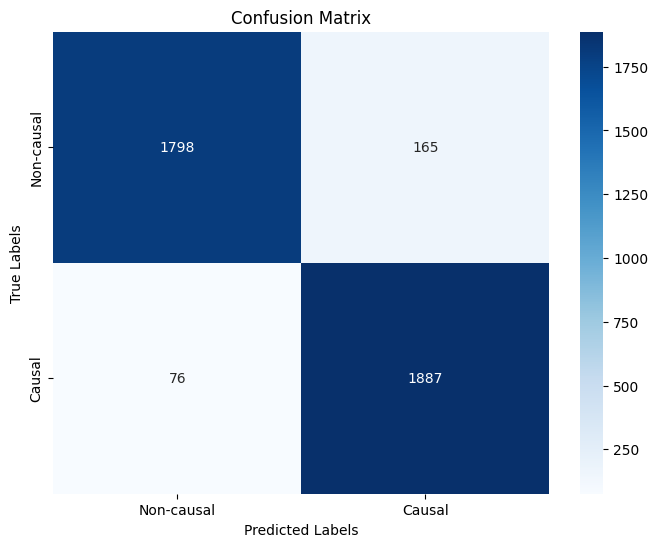

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizer, PreTrainedModel

class SimpleDataset(Dataset):
    def __init__(self, texts, labels, sources):
        self.texts = texts
        self.labels = labels
        self.sources = sources  # Store source column
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {'sentence': self.texts[idx], 'label': self.labels[idx], 'source': self.sources[idx]}  # Include source

def plot_confusion_matrix(true_labels, predicted_labels, labels=["Non-causal", "Causal"]):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate(
        model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        dataset, batch_size=8
        ):

    texts = [item['sentence'] for item in dataset]
    labels = [item['label'] for item in dataset]
    sources = [item['source'] for item in dataset] if 'source' in dataset[0] else ["Unknown"] * len(dataset)  # Handle missing source

    simple_dataset = SimpleDataset(texts, labels, sources)

    def collate_fn(batch):
        texts = [item['sentence'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch])
        sources = [item['source'] for item in batch]  # Include source

        encoding = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
        encoding['labels'] = labels
        encoding['sentences'] = texts  # Retain the original sentences for misclassification tracking
        encoding['sources'] = sources  # Retain source column

        return encoding

    dataloader = DataLoader(simple_dataset, batch_size=batch_size, collate_fn=collate_fn)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    true_labels = []
    predicted_labels = []
    misclassified_examples = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            inputs = {key: val.to(device) for key, val in batch.items() if key not in ['labels', 'sentences', 'sources']}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true_batch_labels = batch['labels'].cpu().numpy()
            true_labels.extend(true_batch_labels)
            predicted_labels.extend(preds)

            for i in range(len(preds)):
                if preds[i] != true_batch_labels[i]:  # Only store misclassified examples
                    misclassified_examples.append({
                        'sentence': batch['sentences'][i],  # Original sentence
                        'true_label': true_batch_labels[i],
                        'predicted_label': preds[i],
                        'source': batch['sources'][i]  # Include source
                    })

    class_report = classification_report(true_labels, predicted_labels, target_names=["Non-causal", "Causal"])
    print("Classification Report:")
    print("=================================")
    print(class_report)
    print("=================================")

    misclassified_df_imbalanced = pd.DataFrame(misclassified_examples)
    misclassified_df_imbalanced.to_csv('misclassified_sentences.csv', index=False)
    print("Misclassified sentences saved to 'misclassified_sentences.csv'.")

    return true_labels, predicted_labels

true_labels, predicted_labels = evaluate(model, tokenizer, datasets['test'])

plot_confusion_matrix(true_labels, predicted_labels)


In [45]:
misclassifiers= pd.read_csv('/kaggle/working/misclassified_sentences.csv')
misclassifiers

,sentence,true_label,predicted_label,source
0,differences emerged suggesting worse health among those who gave birth,1,0,Haber
1,Using logistic regression we found African Americans were no different from Whites in seeking health information and using it when they talked with their doctors.,1,0,Haber
2,The performance of TaETM achieves the same results in terms of quality of life and anorectal function as conventional ETM.,1,0,Pubmed data.csv
3,"Because of the partner design, this yields 18 independent observations for each treatment.",1,0,Ssc
4,Registers are used for the most frequently needed data items to avoid having to access main memory every time data is needed .,1,0,altlex
...,...,...,...,...
236,"Using Campbell's (1958) concept of `entitativity', they also assume that the competitive discontinuity between individuals and groups is greater the more members Discontinuity or reciprocity?",0,1,Ssc
237,High-normal TSH (3.0 mIU/L) and lower TSH (<0.5 mIU/L) levels were associated with higher death risk,0,1,Haber
238,First Nations and Inuit infants had substantially elevated burdens of hospitalizations as a result of diseases of multiple systems.,0,1,Haber
239,"However, training and experience of nurses in aromatherapy massage is critical to achieving positive results.",0,1,Pubmed data.csv


In [8]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model and tokenizer
model_path = '/kaggle/input/2_bert_final/pytorch/default/1/2_BERT_final' 
model_name = "BERT"
initialize_model(model_name, config)
# Move the model to the appropriate device
model.to(device)

def classify_sentence(sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).item()  # Get the predicted class

    return predictions

# Example usage
sentence = "Mini Nutritional Assessment was able to predict the development of PUs.	"
prediction = classify_sentence(sentence)

# Print the result
print(f"The predicted class for the sentence is: {prediction}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
The predicted class for the sentence is: 1


Classification Report:
              precision    recall  f1-score   support

  Non-causal       0.93      0.88      0.90        96
      Causal       0.88      0.94      0.91        96

    accuracy                           0.91       192
   macro avg       0.91      0.91      0.91       192
weighted avg       0.91      0.91      0.91       192

Misclassified sentences saved to 'misclassified_sentences_ssc.csv'.


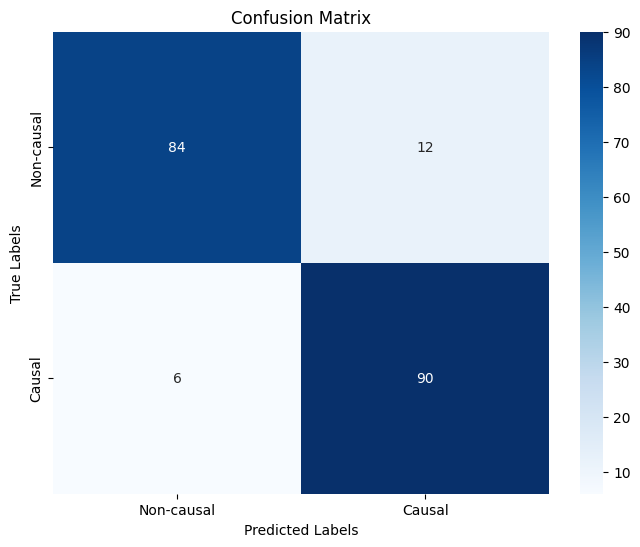

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizer, PreTrainedModel

class SimpleDataset(Dataset):
    def __init__(self, texts, labels, sources):
        self.texts = texts
        self.labels = labels
        self.sources = sources  # Store source column
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {'sentence': self.texts[idx], 'label': self.labels[idx], 'source': self.sources[idx]}  # Include source

def plot_confusion_matrix(true_labels, predicted_labels, labels=["Non-causal", "Causal"]):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate(
        model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        dataset, batch_size=8
        ):

    texts = [item['sentence'] for item in dataset]
    labels = [item['label'] for item in dataset]
    sources = [item['source'] for item in dataset] if 'source' in dataset[0] else ["Unknown"] * len(dataset)  # Handle missing source

    simple_dataset = SimpleDataset(texts, labels, sources)

    def collate_fn(batch):
        texts = [item['sentence'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch])
        sources = [item['source'] for item in batch]  # Include source

        encoding = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
        encoding['labels'] = labels
        encoding['sentences'] = texts  # Retain the original sentences for misclassification tracking
        encoding['sources'] = sources  # Retain source column

        return encoding

    dataloader = DataLoader(simple_dataset, batch_size=batch_size, collate_fn=collate_fn)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    true_labels = []
    predicted_labels = []
    misclassified_examples = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            inputs = {key: val.to(device) for key, val in batch.items() if key not in ['labels', 'sentences', 'sources']}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true_batch_labels = batch['labels'].cpu().numpy()
            true_labels.extend(true_batch_labels)
            predicted_labels.extend(preds)

            for i in range(len(preds)):
                if preds[i] != true_batch_labels[i]:  # Only store misclassified examples
                    misclassified_examples.append({
                        'sentence': batch['sentences'][i],  # Original sentence
                        'true_label': true_batch_labels[i],
                        'predicted_label': preds[i],
                        'source': batch['sources'][i]  # Include source
                    })

    class_report = classification_report(true_labels, predicted_labels, target_names=["Non-causal", "Causal"])
    print("Classification Report:")
    print("=================================")
    print(class_report)
    print("=================================")

    misclassified_df_imbalanced = pd.DataFrame(misclassified_examples)
    misclassified_df_imbalanced.to_csv('misclassified_sentences_ssc.csv', index=False)
    print("Misclassified sentences saved to 'misclassified_sentences_ssc.csv'.")

    return true_labels, predicted_labels

true_labels, predicted_labels = evaluate(model, tokenizer, datasets['test_ssc'])

plot_confusion_matrix(true_labels, predicted_labels)


In [50]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False) 
misclassified=pd.read_csv("/kaggle/working/misclassified_sentences_ssc.csv")
misclassified

,sentence,true_label,predicted_label,source
0,Both effects should cause increase in public-good provision at least at level 1.,1,0,Ssc
1,"Further, because direct reciprocity was not possible in our experiments, sharing arrangements were not self-enforcing.",1,0,Ssc
2,"Thus, much like the real world, if harvesters mismanaged the resource during the early stages of the simulation, there was less available during the later stages.",1,0,Ssc
3,Previous research has shown that behavior aligns with self-interest only when self-interest is salient.,1,0,Ssc
4,"Because of the partner design, this yields 18 independent observations for each treatment.",1,0,Ssc
5,"Otherwise, if the accumulated gain explains the behaviour of the birds but the one trial gain does not, then the birds are making decisions based on the four trial reward and are playing a mutualism game.",1,0,Ssc
6,This effect would be due primarily to the significantly lower amount of cooperation for subjects assigned to the low potential reward position.,0,1,Ssc
7,The present results indicate that the failure might not be due to an unrepresentativeness of game situations to typical interpersonal interactions.,0,1,Ssc
8,"The correlation between contributions and other-team beliefs is lower (Spearman's = 0.31, p < 0.01), but still indicative of a positive relationship.",0,1,Ssc
9,"First, we can assess the correlation between beliefs and contributions, which we expect to differ between types of players and which helps us to check on the player type as elicited in the P-experiment.",0,1,Ssc


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
from torch.nn.functional import softmax

model_path = '/kaggle/input/2_bert_final/pytorch/default/1/2_BERT_final' 

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
def apply_temperature_scaling(logits, temperature=1.0):
    """
    Apply temperature scaling to logits before softmax to calibrate the output.
    """
    scaled_logits = logits / temperature
    return scaled_logits

def evaluate_with_visualization(model, tokenizer, dataset, temperature=1.0, batch_size=8):
    """
    Evaluate the model and return confidence scores for correct and incorrect predictions.
    """
    def collate_fn(batch):
        texts = [item['sentence'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch])
        return {'texts': texts, 'labels': labels}

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    confidences_correct = []
    confidences_incorrect = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(batch['texts'], truncation=True, padding=True, max_length=512, return_tensors="pt")
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = batch['labels'].to(device)

            logits = model(**inputs).logits
            scaled_logits = apply_temperature_scaling(logits, temperature)
            probs = F.softmax(scaled_logits, dim=-1)

            confidences = torch.max(probs, dim=1).values.cpu().numpy()
            predictions = torch.argmax(probs, dim=1).cpu().numpy()

            correct = confidences[predictions == labels.cpu().numpy()]
            incorrect = confidences[predictions != labels.cpu().numpy()]

            confidences_correct.extend(correct)
            confidences_incorrect.extend(incorrect)

            torch.cuda.empty_cache()

    return np.array(confidences_correct), np.array(confidences_incorrect)

def find_cutoff_with_margin_and_threshold(incorrect_confidences, target_tpr=0.80):
    sorted_incorrect = np.sort(incorrect_confidences)
    target_index = int(target_tpr * len(sorted_incorrect))

    if target_index >= len(sorted_incorrect):
        target_index = len(sorted_incorrect) - 1
    elif target_index < 0:
        target_index = 0

    best_cutoff = sorted_incorrect[target_index]
    return best_cutoff

def calculate_tpr_fpr(correct_confidences, incorrect_confidences, best_cutoff):
    tpr = np.sum(incorrect_confidences <= best_cutoff) / len(incorrect_confidences)
    fpr = np.sum(correct_confidences <= best_cutoff) / len(correct_confidences)
    return tpr, fpr

def plot_density_with_cutoff(correct_confidences, incorrect_confidences, best_cutoff, temperature):
    plt.figure(figsize=(8, 5))  # Reduce the figure size

    sns.kdeplot(correct_confidences, label="Correct Predictions", fill=True, alpha=0.5, color="blue", bw_adjust=0.5)
    sns.kdeplot(incorrect_confidences, label="Misclassified Predictions", fill=True, alpha=0.5, color="red", bw_adjust=0.5)
    plt.axvline(x=best_cutoff, color='black', linestyle='--', label=f"Best Cutoff = {best_cutoff:.4f}")

    plt.xlim(0.4, 1)  # Adjust x-axis to start at 0.4
    plt.title(f"Confidence Score Density (Temperature = {temperature})")
    plt.xlabel("Confidence Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

batch_size = 8
temperature = 1.0
TARGET_TPR = 0.50

# Evaluate model and obtain confidence scores
confidences_correct, confidences_incorrect = evaluate_with_visualization(
    model, tokenizer, datasets['test'], temperature=temperature, batch_size=batch_size
)

confidences_correct = np.clip(confidences_correct, 0, 1)
confidences_incorrect = np.clip(confidences_incorrect, 0, 1)

# Find cutoff for target TPR
best_cutoff = find_cutoff_with_margin_and_threshold(confidences_incorrect, TARGET_TPR)

# Calculate TPR and FPR at the cutoff
tpr, fpr = calculate_tpr_fpr(confidences_correct, confidences_incorrect, best_cutoff)

# Plot density distributions with the cutoff
plot_density_with_cutoff(confidences_correct, confidences_incorrect, best_cutoff, temperature)

# Print results
print(f"Best Cutoff: {best_cutoff:.4f}")
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")


NameError: name 'datasets' is not defined

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
from torch.nn.functional import softmax

model_path = '/kaggle/input/causality-detection-bert-final/pytorch/default/1/BERT_final' 

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

def apply_temperature_scaling(logits, temperature=1.0):
    """
    Apply temperature scaling to logits before softmax to calibrate the output.
    """
    scaled_logits = logits / temperature
    return scaled_logits

def evaluate_with_visualization(model, tokenizer, dataset, temperature=1.0, batch_size=8):
    """
    Evaluate the model and return confidence scores for correct and incorrect predictions.
    """
    def collate_fn(batch):
        texts = [item['sentence'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch])
        return {'texts': texts, 'labels': labels}

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    confidences_correct = []
    confidences_incorrect = []
    confidences_per_class = {0: [], 1: []}  # To store confidence per class (non-causal, causal)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(batch['texts'], truncation=True, padding=True, max_length=512, return_tensors="pt")
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = batch['labels'].to(device)

            logits = model(**inputs).logits
            scaled_logits = apply_temperature_scaling(logits, temperature)
            probs = F.softmax(scaled_logits, dim=-1)

            confidences = torch.max(probs, dim=1).values.cpu().numpy()
            predictions = torch.argmax(probs, dim=1).cpu().numpy()

            correct = confidences[predictions == labels.cpu().numpy()]
            incorrect = confidences[predictions != labels.cpu().numpy()]

            confidences_correct.extend(correct)
            confidences_incorrect.extend(incorrect)

            # Store confidences per class
            for label, confidence in zip(labels.cpu().numpy(), confidences):
                confidences_per_class[label].append(confidence)

            torch.cuda.empty_cache()

    return np.array(confidences_correct), np.array(confidences_incorrect), confidences_per_class

def find_cutoff_with_margin_and_threshold(incorrect_confidences, target_tpr=0.85):
    sorted_incorrect = np.sort(incorrect_confidences)
    target_index = int(target_tpr * len(sorted_incorrect))

    if target_index >= len(sorted_incorrect):
        target_index = len(sorted_incorrect) - 1
    elif target_index < 0:
        target_index = 0

    best_cutoff = sorted_incorrect[target_index]
    return best_cutoff

def calculate_tpr_fpr(correct_confidences, incorrect_confidences, best_cutoff):
    tpr = np.sum(incorrect_confidences <= best_cutoff) / len(incorrect_confidences)
    fpr = np.sum(correct_confidences <= best_cutoff) / len(correct_confidences)
    return tpr, fpr

def plot_density_with_cutoff(correct_confidences, incorrect_confidences, best_cutoff, temperature):
    plt.figure(figsize=(8, 5))  # Reduce the figure size
    sns.kdeplot(correct_confidences, label="Correct Predictions", fill=True, alpha=0.5, color="blue", bw_adjust=0.5)
    sns.kdeplot(incorrect_confidences, label="Misclassified Predictions", fill=True, alpha=0.5, color="red", bw_adjust=0.5)
    plt.axvline(x=best_cutoff, color='black', linestyle='--', label=f"Best Cutoff = {best_cutoff:.4f}")
    plt.xlim(0.4, 1)  # Adjust x-axis to start at 0.4
    plt.title(f"Confidence Score Density (Temperature = {temperature})")
    plt.xlabel("Confidence Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

batch_size = 8
temperature = 1
TARGET_TPR = 0.85

# Evaluate model and obtain confidence scores
confidences_correct, confidences_incorrect, confidences_per_class = evaluate_with_visualization(
    model, tokenizer, datasets['test'], temperature=temperature, batch_size=batch_size
)

confidences_correct = np.clip(confidences_correct, 0, 1)
confidences_incorrect = np.clip(confidences_incorrect, 0, 1)

# Find cutoff for target TPR
best_cutoff = find_cutoff_with_margin_and_threshold(confidences_incorrect, TARGET_TPR)

# Calculate TPR and FPR at the cutoff
tpr, fpr = calculate_tpr_fpr(confidences_correct, confidences_incorrect, best_cutoff)

# Plot density distributions with the cutoff
plot_density_with_cutoff(confidences_correct, confidences_incorrect, best_cutoff, temperature)

# Print results
print(f"Best Cutoff: {best_cutoff:.4f}")
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")

# Average confidence per class (non-causal vs. causal)
avg_confidence_per_class = {key: np.mean(val) for key, val in confidences_per_class.items()}
print(f"Average Confidence per Class: {avg_confidence_per_class}")

# Confidence for correct and incorrect predictions
avg_confidence_correct = np.mean(confidences_correct)
avg_confidence_incorrect = np.mean(confidences_incorrect)
print(f"Average Confidence for Correct Predictions: {avg_confidence_correct:.4f}")
print(f"Average Confidence for Incorrect Predictions: {avg_confidence_incorrect:.4f}")

# Create DataFrame for export
data = {
    'Class 0 Average Confidence': [avg_confidence_per_class.get(0, 0)],
    'Class 1 Average Confidence': [avg_confidence_per_class.get(1, 0)],
    'Avg Confidence Correct': [avg_confidence_correct],
    'Avg Confidence Incorrect': [avg_confidence_incorrect],
    'Best Cutoff': [best_cutoff],
    'TPR': [tpr],
    'FPR': [fpr]
}

df = pd.DataFrame(data)

# Export to CSV
df.to_csv('grobid_confidences.csv', index=False)

In [ ]:
import shutil

shutil.make_archive('/kaggle/working/BERT3_sci', 'zip', '/kaggle/working', 'BERT3_sci')